In [1]:
import sys
sys.path.append("/home/macbuse/miniconda3/lib/python3.11/site-packages")

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats as stats

/tmp/ipykernel_11573/1822434047.py:7: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  import scipy.stats as stats


# comments

- Polysa's urns took a bit of time for me but I think the simulation is better as the code is close to what you would do in **C**


```
long long* get_sim_urne(int r, int b, int N) {
    int total_final = r + b + N;
    long long* urne = (long long*)calloc(total_final, sizeof(long long));

    for (int i = 0; i < r; i++) {
        urne[i] = 1;
    }

    for (int i = r + b; i < total_final; i++) {
        int idx = rand() % i; 
        urne[i] = urne[idx];
    }

    return urne;
}
```

- otherwise using **numba** with **@njit** allows u to do more interesting simulations and u had already pulled the simulations out as functions which are easy to compile


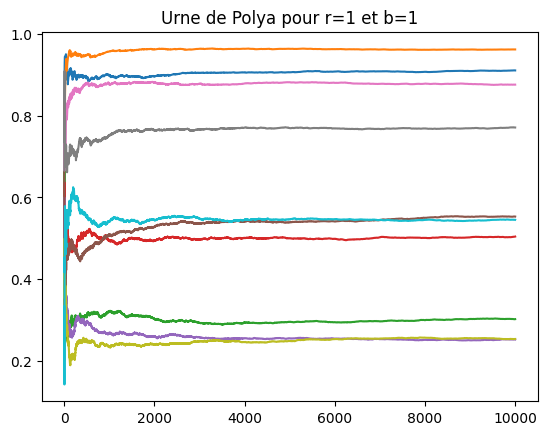

In [2]:
## Exo 1
r = 1
b = 1
N = 10000
Nsim = 10

for i in range(0, Nsim):
    # the interior loop should be a function
    urne = np.concatenate((np.ones(r),np.zeros(b)))
    X = np.zeros(N)
    for i in range(0,N):
        I = np.array([npr.choice(urne)])
        # I would replace concatenate with an assignment
        urne = np.concatenate((urne,I))
        X[i] = np.mean(urne)
    plt.plot(np.arange(1,N+1),X)
    
plt.title(f'Urne de Polya pour r={r} et b={b}')
plt.show()
# Il semble bien que la proportion converge, mais vers une limite aléatoire


## alternative to calculating a rolling average in the loop

This  uses:
- fixed length arrays to avoid **append**
- vectorisation to calculate the proportions quicker <br>
  ```proportions_rouge = np.cumsum(urne) / np.arange(1, len(urne) + 1)```


In [21]:
# should use @jit or @njit 
# with numba (see below)

def get_sim_urne(r=1, b=1, N=1000):
    # use a fixed length array of integers
    urne = np.zeros(r + b + N, dtype=np.int64)
    urne[:r] = 1 # Initialisation rouges
    
    # Boucle optimisée pour Numba
    for i in range(r + b, r + b + N):
        # npr.randint pour la vitesse maximale avec numba
        # avoids npr.choice 
        idx = npr.randint(0, i)
        urne[i] = urne[idx]      
    return urne
    

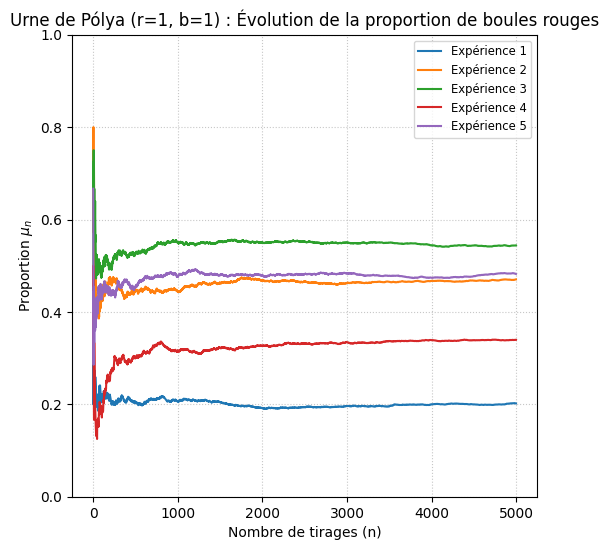

In [34]:
Nsim = 5
r = b = 1

# Création de la figure et de l'axe de manière sécurisée
fig, ax = plt.subplots(figsize=(6, 6))

for j in range(Nsim):
    urne  = get_sim_urne(r=r, b=b, N=5000)
    #calculate proportions
    proportions_rouge = np.cumsum(urne) / np.arange(1, len(urne) + 1)
    #ignore filling initial urne
    Y = proportions_rouge[r+b:]
    ax.plot(np.arange(0, len(Y)), Y, 
            label=f'Expérience {j+1}')


ax.set_title(f'Urne de Pólya (r={r}, b={b}) : Évolution de la proportion de boules rouges')
ax.set_xlabel('Nombre de tirages (n)')
ax.set_ylabel('Proportion $\mu_n$')
ax.set_ylim(0, 1) # La proportion est toujours entre 0 et 1
ax.grid(True, linestyle=':', alpha=0.7)
ax.legend(loc='upper right', fontsize='small')

plt.show()


---

## Remarks 

Il semble bien que la proportion converge, mais vers une limite aléatoire

- stability?
    - so if r=b=1 it's unstable but...
    - what if r=b=n with n >> 1 ?

---


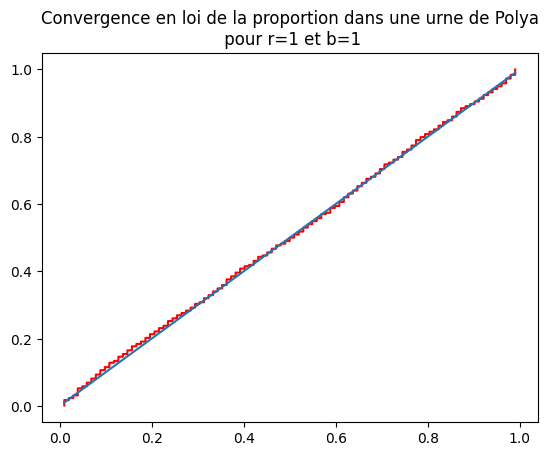

In [20]:

Nsim = 1000
N = 100
r = b = 1
Y = np.zeros(Nsim)

for i in range(0,Nsim):
    urne = np.concatenate((np.ones(r),np.zeros(b)))
    for j in range(0,N):
        I = np.array([npr.choice(urne)])
        # I would replace concatenate with an assignment
        urne = np.concatenate((urne,I))
    Y[i] = np.mean(urne)
    
Ys = sorted(Y)
x=np.linspace(min(Y),max(Y),num=100)

plt.step(Ys,np.arange(1,Nsim+1)/Nsim,
         color='r',where='post')
plt.plot(x, stats.beta(r,b).cdf(x))
plt.title(f'Convergence en loi de la proportion dans une urne de Polya\n pour r={r} et b={b}')
plt.show()


In [50]:
# reinstall numba using conda

from numba import njit


# Compile with the jit

- ... before doing the simulation
- this means you can work with much bigger N without a wait


In [43]:
@njit

def get_sim_urne(r=1, b=1, N=1000):
    # use a fixed length array of integers
    urne = np.zeros(r + b + N, dtype=np.int64)
    urne[:r] = 1 # Initialisation rouges
    
    # Boucle optimisée pour Numba
    for i in range(r + b, r + b + N):
        # npr.randint pour la vitesse maximale
        # avoids npr.choice 
        idx = npr.randint(0, i)
        urne[i] = urne[idx]      
    return urne
    

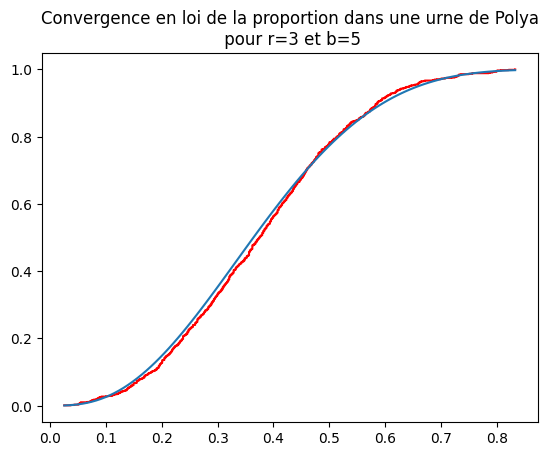

In [51]:
Nsim = 1000
Y = np.zeros(Nsim)
r = 3
b = 5

for i in range(0,Nsim):
    # this is to disable the code in the loop
    continue
    urne = get_sim_urne(r=r,b=b,N=1000)
    Y[i] = np.mean(urne)

# technically you can do this as a list comprehension now
# so you don't need to initialise Y 
Y = [np.mean(get_sim_urne(r=r,b=b,N=500)) for _ in range(0,Nsim) ]

Ys = sorted(Y)

# same comment about min and max = Ys[0], Ys[-1]
Xs =np.linspace(min(Y),max(Y),num=100)

#why not np.linspace(0,1,Nsim) ?
plt.step(Ys,np.arange(1,Nsim+1)/Nsim,
         color='r',where='post')
plt.plot(Xs, stats.beta(r,b).cdf(Xs))
plt.title(f'Convergence en loi de la proportion dans une urne de Polya\n pour r={r} et b={b}')
plt.show()

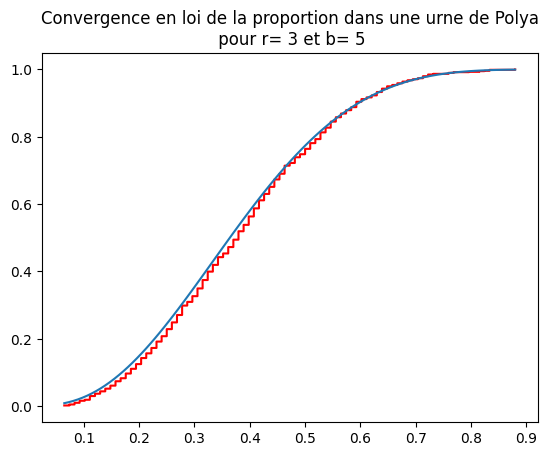

In [38]:
#
Nsim = 1000
N = 100
r = 3
b = 5
Y = np.zeros(Nsim)

for i in range(0,Nsim):
    urne=np.concatenate((np.ones(r),np.zeros(b)))
    for j in range(0,N):
        I=np.array([npr.choice(urne)])
        urne=np.concatenate((urne,I))
    Y[i]=np.mean(urne)
    
Ys=sorted(Y)
x=np.linspace(min(Y),max(Y),num=100)
plt.figure()
plt.step(Ys,np.arange(1,Nsim+1)/Nsim,color='r',where='post')
plt.plot(x,stats.beta(r,b).cdf(x))
plt.title('Convergence en loi de la proportion dans une urne de Polya\n pour r= '+str(r) + ' et b= ' + str(b))
plt.show()

---

# exo 2

- [gh code](https://stephens999.github.io/fiveMinuteStats/wright_fisher_model.html)
- [wiki](https://en.wikipedia.org/wiki/Genetic_drift)
### 1. Le paramètre $N$ : Taille de la population
Dans le modèle de Wright-Fisher, $N$ représente le nombre total d'individus dans la population. On considère que cette taille reste **constante** à chaque génération.

* **L'enjeu mathématique** : $N$ définit l'espace d'état du processus. À chaque étape, le nombre d'individus possédant le gène étudié ne peut être qu'un entier compris entre $0$ et $N$.
* **L'effet de dérive** : Plus $N$ est petit, plus le hasard a d'impact. Pour un $N$ faible, les trajectoires atteignent très vite les bords (0 ou $N$). C'est ce qu'on appelle la **dérive génétique**.



### 2. Le paramètre $x_0$ : État initial
Le paramètre $x_0$ est le nombre d'individus porteurs du gène de type A au début de l'expérience (génération 0).

* **La fréquence initiale** : Elle est donnée par le rapport $p_0 = x_0 / N$.
* **Probabilité de fixation** : Un résultat classique du modèle est que la probabilité que le gène finisse par être possédé par *toute* la population (fixation à $N$) est exactement égale à $x_0/N$. 
* **Point de départ** : Graphiquement, c'est la valeur sur l'axe des ordonnées où toutes les courbes commencent à $t=0$.

---

### Résumé de la dynamique
Le passage d'une génération à l'autre se fait par un tirage de loi binomiale :
$$X_{j} \sim \mathcal{B}\left(N, \frac{X_{j-1}}{N}\right)$$

1. On regarde la proportion actuelle ($X_{j-1}/N$).
2. On tire $N$ nouveaux individus avec cette probabilité de succès.
3. Le résultat $X_j$ devient la nouvelle base pour la génération suivante.

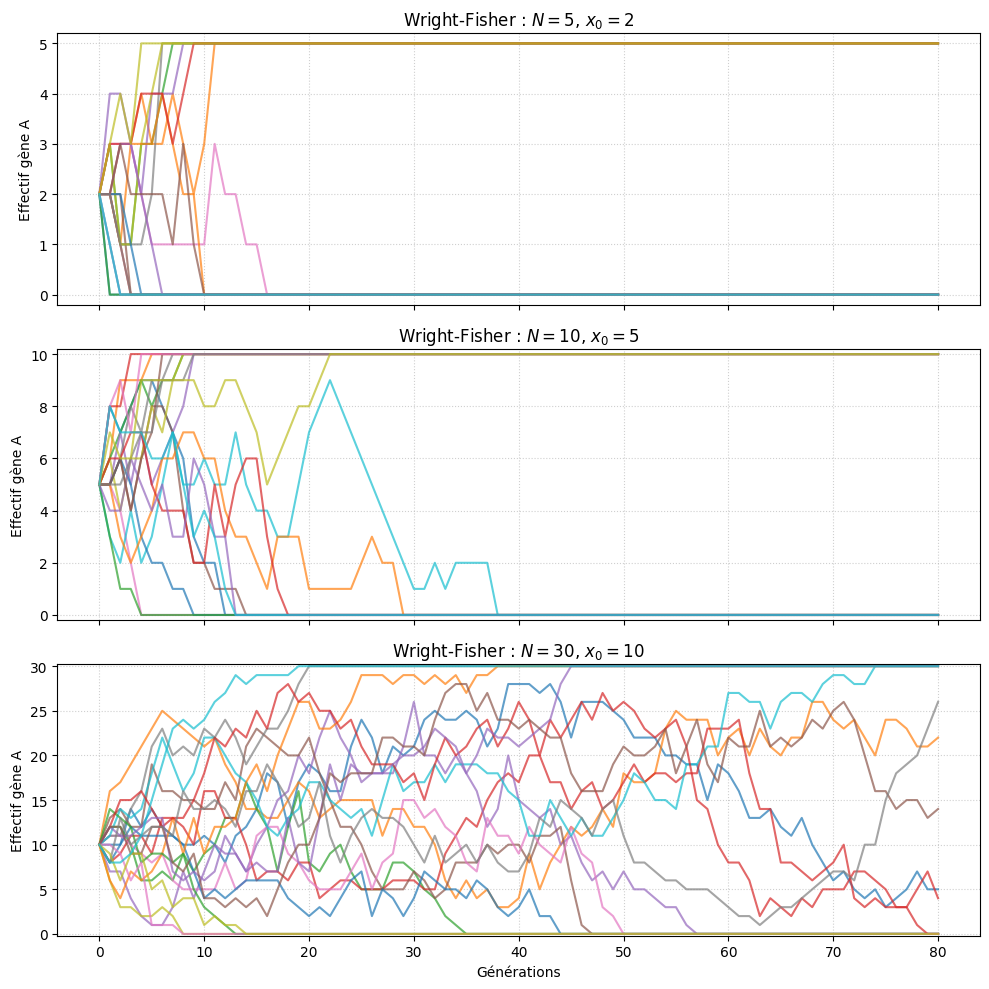

In [61]:
#q1

@njit
def do_sim_wf(x0, n_gen, N, n_sim):
    X = np.zeros((n_sim, n_gen + 1), dtype=np.int64)
    X[:, 0] = x0
    for i in range(n_sim):
        for j in range(1, n_gen + 1):
            X[i, j] = npr.binomial(N, X[i, j-1] / N)
    return X

# --- Paramètres de boucle ---
list_N = [5, 10,30]
list_x0 = [2, 5,10]

Nsim = 20
n_gen = 80

# Création d'une figure avec 2 lignes et 1 colonne
fig, axes = plt.subplots(len(list_N), 1, 
                         figsize=(10, 10), 
                         sharex=True)

# Boucle zip sur les axes et les paramètres
for ax, N, x0 in zip(axes, list_N, list_x0):
    # Calcul
    X = do_sim_wf(x0, n_gen, N, Nsim)
    
    # Tracé (X.T pour avoir les générations en abscisse)
    ax.plot(np.arange(n_gen + 1), X.T, alpha=0.7)
    
    # Configuration de l'axe
    ax.set_title(f"Wright-Fisher : $N={N}$, $x_0={x0}$")
    ax.set_ylabel("Effectif gène A")
    ax.set_ylim(-0.2, N + 0.2)
    ax.grid(True, linestyle=':', alpha=0.6)

axes[-1].set_xlabel("Générations")
plt.tight_layout()
plt.show()

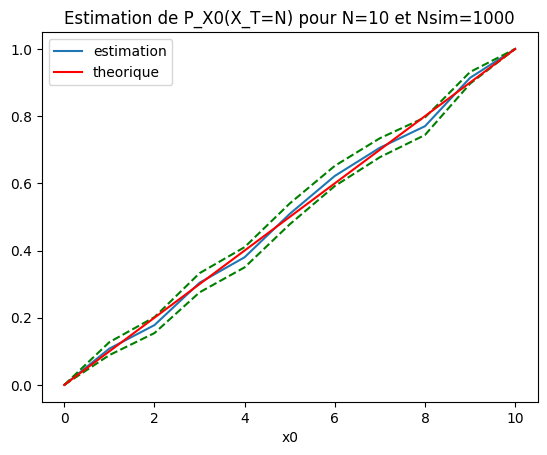

In [69]:
Nsim=1000
N=10
def WFabs(x0,N,Nsim):
    XX=np.zeros(Nsim)
    # i is never used so replace by _
    for i in range(0,Nsim):
        X=x0
        while X!=0 and X!=N:
            X=npr.binomial(N,X/N)
        XX[i]=X==N
    return np.mean(XX)
p=np.zeros(N+1)
for x0 in np.arange(0,N+1):
        p[x0]=WFabs(x0,N,Nsim)
plt.figure()
absc=np.arange(0,N+1)
plt.plot(absc,p,label='estimation')
plt.plot(absc,p+1.96*np.sqrt(p*(1-p))/np.sqrt(Nsim),'--g')
plt.plot(absc,p-1.96*np.sqrt(p*(1-p))/np.sqrt(Nsim),'--g')
plt.plot(absc,absc/N,'r',label='theorique')
plt.xlabel('x0')
plt.title('Estimation de P_X0(X_T=N) pour N='+str(N)+' et Nsim='+str(Nsim))
plt.legend()
plt.show()

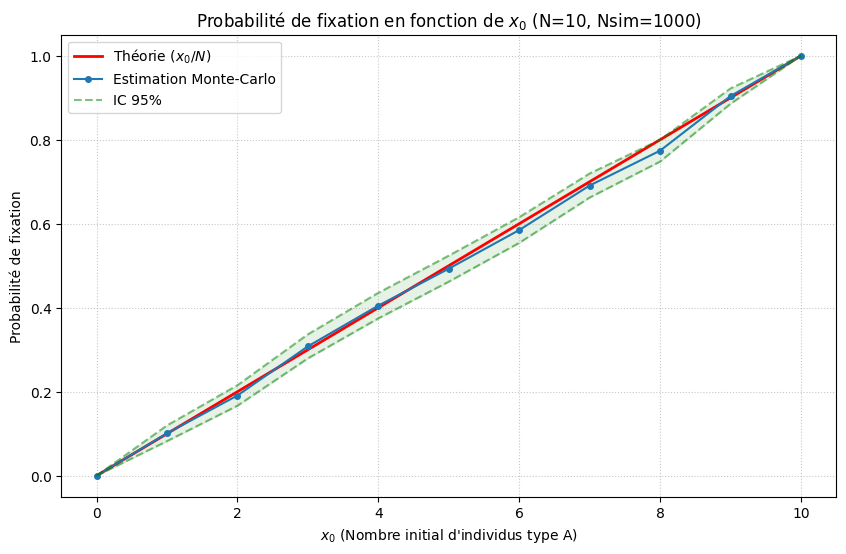

In [72]:
@njit
def simulate_fixation(x0, N, Nsim):
    """Calcule la proportion de fixations à N pour un x0 donné."""
    success_count = 0
    for _ in range(Nsim):
        X = x0
        # On simule jusqu'à l'absorption (0 ou N)
        while X > 0 and X < N:
            X = npr.binomial(N, X / N)
        if X == N:
            success_count += 1
    return success_count / Nsim
# --- Paramètres ---
Nsim = 1000
N = 10
x0_values = np.arange(N + 1)

# --- Calcul des estimations ---
# On applique la fonction compilée à chaque x0
p_est = np.array([simulate_fixation(x, N, Nsim) for x in x0_values])

# --- Calcul vectorisé de l'intervalle de confiance (95%) ---
# IC = p +/- 1.96 * sqrt(p(1-p)/n)
std_error = 1.96 * np.sqrt(p_est * (1 - p_est) / Nsim)
upper_bound = p_est + std_error
lower_bound = p_est - std_error

# --- Tracé avec ax ---
fig, ax = plt.subplots(figsize=(10, 6))

# Droite théorique : y = x/N
ax.plot(x0_values, x0_values / N, 'r', 
        label='Théorie ($x_0/N$)', linewidth=2)

# Estimation numérique
ax.plot(x0_values, p_est, 'o-', 
        label='Estimation Monte-Carlo', markersize=4)

# Intervalle de confiance (représentation par zone ombrée ou pointillés)
ax.plot(x0_values, upper_bound, '--g', 
        alpha=0.5, label='IC 95%')
ax.plot(x0_values, lower_bound, '--g', 
        alpha=0.5)
ax.fill_between(x0_values, lower_bound, upper_bound,
                color='green', alpha=0.1)

# Configuration
ax.set_xlabel('$x_0$ (Nombre initial d\'individus type A)')
ax.set_ylabel('Probabilité de fixation')
ax.set_title(f'Probabilité de fixation en fonction de $x_0$ (N={N}, Nsim={Nsim})')
ax.legend()
ax.grid(True, linestyle=':', alpha=0.7)

plt.show()

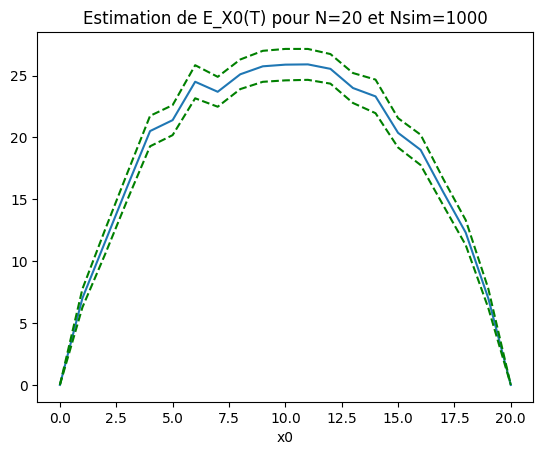

In [75]:
#q3

Nsim=1000
N=20
def WFtps(x0,N,Nsim):
    TT=np.zeros(Nsim)
    for i in range(0,Nsim):
        X=x0
        t=0
        while X!=0 and X!=N:
            X=npr.binomial(N,X/N)
            t=t+1
        TT[i]=t
    return [np.mean(TT),np.std(TT)]
tps=np.zeros(N+1)
s=np.zeros(N+1)
for x0 in np.arange(0,N+1):
    a=WFtps(x0,N,Nsim)
    tps[x0]=a[0]
    s[x0]=a[1]
plt.figure()
absc=np.arange(0,N+1)
plt.plot(absc,tps)
plt.plot(absc,tps+1.96*s/np.sqrt(Nsim),'--g')
plt.plot(absc,tps-1.96*s/np.sqrt(Nsim),'--g')
plt.xlabel('x0')
plt.title('Estimation de E_X0(T) pour N='+str(N)+' et Nsim='+str(Nsim))
plt.show()

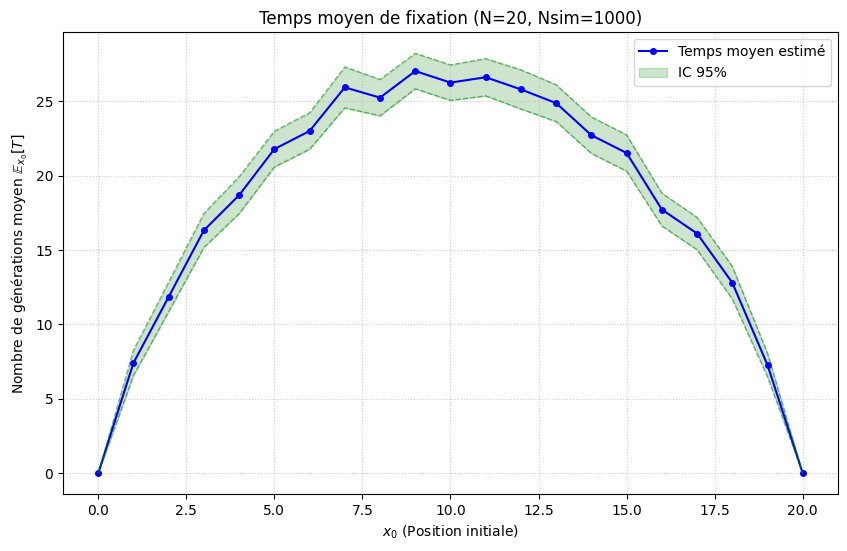

In [79]:
@njit
def simulate_fixation_time(x0, N, Nsim):
    """Calcule la moyenne et l'écart-type du temps d'absorption."""
    times = np.zeros(Nsim)
    for i in range(Nsim):
        X,t = x0, 0
        while 0 < X < N:
            X = npr.binomial(N, X / N)
            t += 1
        times[i] = t
    return np.mean(times), np.std(times)

# --- Paramètres ---
Nsim = 1000
N = 20
x0_values = np.arange(N + 1)

# --- Calculs ---
# Initialisation des tableaux de résultats
mean_times = np.zeros(N + 1)
std_devs = np.zeros(N + 1)

for x0 in x0_values:
    m, s = simulate_fixation_time(x0, N, Nsim)
    mean_times[x0] = m
    std_devs[x0] = s

# --- Calcul de l'intervalle de confiance (95%) ---
error_margin = 1.96 * std_devs / np.sqrt(Nsim)

# --- Tracé ---
fig, ax = plt.subplots(figsize=(10, 6))

# Ligne principale
ax.plot(x0_values, mean_times, 'b-o', markersize=4, label='Temps moyen estimé')

# Intervalle de confiance avec fill_between pour la lisibilité
ax.fill_between(x0_values, 
                mean_times - error_margin, 
                mean_times + error_margin, 
                color='green', alpha=0.2, label='IC 95%')

# Bornes de l'IC en pointillés
ax.plot(x0_values, mean_times + error_margin, '--g', alpha=0.5, linewidth=1)
ax.plot(x0_values, mean_times - error_margin, '--g', alpha=0.5, linewidth=1)

# Configuration
ax.set_xlabel('$x_0$ (Position initiale)')
ax.set_ylabel('Nombre de générations moyen $\mathbb{E}_{x_0}[T]$')
ax.set_title(f'Temps moyen de fixation (N={N}, Nsim={Nsim})')
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend()

plt.show()


### Améliorations apportées :

1. **Vitesse (Numba)** : La boucle `while` à l'intérieur de la boucle `Nsim` est désormais compilée. C'est crucial ici car pour  et  large, le temps de fixation peut devenir très long.
2. **Unpacking propre** : `m, s = simulate_fixation_time(...)` remplace l'accès par indice `a[0], a[1]`, ce qui rend le code plus lisible.
3. **Visualisation** : L'utilisation de `fill_between` permet de mieux voir la forme de la courbe. On observe bien une forme concave (en "cloche" inversée), montrant que le temps de fixation est maximal lorsque la diversité génétique initiale est maximale ().
4. **Gestion des axes** : `ax.set_xlabel` et les titres avec LaTeX rendent le graphique prêt pour un document pédagogique.


In [80]:
! ../.g

[master 0b3d478] web
 2 files changed, 557 insertions(+), 25 deletions(-)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 823.59 KiB | 5.38 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 2 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   3ee1d83..0b3d478  master -> master
